In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pyscipopt
import time
import pickle
from pyscipopt import Model
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from data_loader import *
from utils import *
from bandit_utils import *

from enviornment import Enviornment
from reward import Reward
from lin_ucb import LinUCB

## Linear UCB on 5 minutes MIP instances

In [2]:
time_limit_in_mins = 5

In [3]:
actions = [{'veclendiving' : -1}, {'veclendiving' : 1}, {'veclendiving' : 10}]
action_values = list(map(lambda x: list(x.values())[0], actions))

seeds = [0,1,2,3,4]
priority_or_freq = 'freq'
min_time_to_solve = 5
max_rows = 100000
max_cols = 100000

max_primal_integral = time_limit_in_mins * 60 # set to no primal bound found in time limit
reward_path_prefix = '../solved_mip_results/rewards_' + str(time_limit_in_mins) +'_min/'
primal_integral_path_prefix = '../solved_mip_results/primal_integrals_' + str(time_limit_in_mins) +'_min/'

# dimension of state
state_dim = 5

In [4]:
# training parameters
episodes = 1000
n_runs = 25
seed = 1

# bandit parameters
results_dict_5_min = {}
#alphas = [1.0, 10.0]
alphas = [0.1, 0.5, 1.0, 5.0, 10.0]

In [5]:
# load instances
instances = get_instances(actions = actions, 
                          seeds = seeds, 
                          priority_or_freq = priority_or_freq, 
                          max_primal_integral = max_primal_integral,
                          min_time_to_solve = min_time_to_solve,
                          max_rows = max_rows,
                          max_cols = max_cols,
                          reward_path_prefix = reward_path_prefix)

In [6]:
# get dict to store all primal integral results to avoid loading files every time
solved_mip_result_dict = get_solved_mip_result_dict(instances, priority_or_freq, actions, action_values, seeds, reward_path_prefix)

In [7]:
# get train/test split
train_instances, test_instances = get_train_test_split(instances, seed=seed)

print('Number of train instances:', len(train_instances))
print('Number of test instances:', len(test_instances))

Number of train instances: 268
Number of test instances: 68


In [8]:
# get scaler for training inputs
scaler = get_scaler_normalize_train_states(train_instances)

In [9]:
start_time = time.time()

np.random.seed(seed)

for alpha in alphas:
    
    print('alpha:', alpha)
    
    # init arrays to store results and bandit
    bandit = LinUCB(action_values, state_dim, alpha)
    train_rewards = []
    test_rewards = []
    
    for run in range(n_runs):

        print('  Run:', run+1)
        

        train_rewards_ep = []
        train_actions_ep = []

        test_rewards_ep = []
        test_actions_ep = []
        
        train_reward, _ = eval_on_all(bandit, train_instances, solved_mip_result_dict=solved_mip_result_dict)
        test_reward, _ = eval_on_all(bandit, test_instances, solved_mip_result_dict=solved_mip_result_dict)

        train_rewards_ep.append(train_reward)
        test_rewards_ep.append(test_reward)

        for episode in range(episodes):

            if (episode + 1) % 100 == 0:
                print('    episode:', episode + 1, 'time:', time.time()-start_time)

            instance, state = get_random_instance(train_instances)

            state = scaler.transform(state.reshape(1,state_dim)).reshape(state_dim,)
            action = bandit.get_action(state)

            reward = take_action_on_instance(solved_mip_result_dict, instance, action,)
            scaled_reward = scale_reward(reward, max_primal_integral)
            
            bandit.update_params(scaled_reward, state, action)

            train_reward, _ = eval_on_all(bandit, train_instances, solved_mip_result_dict=solved_mip_result_dict)
            test_reward, _ = eval_on_all(bandit, test_instances, solved_mip_result_dict=solved_mip_result_dict)

            train_rewards_ep.append(train_reward)
            test_rewards_ep.append(test_reward)

        train_rewards.append(train_rewards_ep)
        test_rewards.append(test_rewards_ep)
    
    results_dict_5_min[alpha] = {
        'train_rewards' : train_rewards,
        'test_rewards' : test_rewards,
        'train_rewards_mean' : np.mean(train_rewards, axis=0),
        'test_rewards_mean' : np.mean(test_rewards, axis=0),
        'train_rewards_std' : np.std(train_rewards, axis=0),
        'test_rewards_std' : np.std(test_rewards, axis=0),
        'bandit' : bandit
    }

alpha: 0.1
  Run: 1
    episode: 100 time: 12.758397817611694
    episode: 200 time: 25.415799140930176
    episode: 300 time: 39.48013663291931
    episode: 400 time: 53.93786430358887
    episode: 500 time: 68.94067668914795
    episode: 600 time: 86.19732713699341
    episode: 700 time: 101.79825043678284
    episode: 800 time: 116.40715885162354
    episode: 900 time: 131.91257238388062
    episode: 1000 time: 148.75928163528442
  Run: 2
    episode: 100 time: 174.69958329200745
    episode: 200 time: 198.4915041923523
    episode: 300 time: 223.61115384101868
    episode: 400 time: 244.94024896621704
    episode: 500 time: 265.9508447647095
    episode: 600 time: 286.388555765152
    episode: 700 time: 307.2436509132385
    episode: 800 time: 329.19301295280457
    episode: 900 time: 351.70960330963135
    episode: 1000 time: 379.05701780319214
  Run: 3
    episode: 100 time: 407.5532829761505
    episode: 200 time: 432.3789632320404
    episode: 300 time: 452.1375710964203
    ep

    episode: 400 time: 3870.046095609665
    episode: 500 time: 3890.5556473731995
    episode: 600 time: 3911.2985990047455
    episode: 700 time: 3931.1246268749237
    episode: 800 time: 3950.7875788211823
    episode: 900 time: 3971.4913680553436
    episode: 1000 time: 3991.2356555461884
  Run: 21
    episode: 100 time: 4011.13946557045
    episode: 200 time: 4030.7321469783783
    episode: 300 time: 4050.4289190769196
    episode: 400 time: 4070.446531534195
    episode: 500 time: 4092.7305936813354
    episode: 600 time: 4113.986157655716
    episode: 700 time: 4133.61501789093
    episode: 800 time: 4153.4956295490265
    episode: 900 time: 4173.7081735134125
    episode: 1000 time: 4193.189078092575
  Run: 22
    episode: 100 time: 4212.924745559692
    episode: 200 time: 4232.40465927124
    episode: 300 time: 4252.17737865448
    episode: 400 time: 4271.689012289047
    episode: 500 time: 4291.4277584552765
    episode: 600 time: 4310.931778669357
    episode: 700 time: 4330

    episode: 900 time: 7771.912834644318
    episode: 1000 time: 7791.55522608757
  Run: 15
    episode: 100 time: 7811.2932415008545
    episode: 200 time: 7831.436481952667
    episode: 300 time: 7851.088599681854
    episode: 400 time: 7870.709521532059
    episode: 500 time: 7892.639289855957
    episode: 600 time: 7914.832034826279
    episode: 700 time: 7934.715930223465
    episode: 800 time: 7954.183129072189
    episode: 900 time: 7973.710238456726
    episode: 1000 time: 7993.2298848629
  Run: 16
    episode: 100 time: 8013.055305242538
    episode: 200 time: 8032.447914361954
    episode: 300 time: 8051.90066742897
    episode: 400 time: 8071.360746860504
    episode: 500 time: 8090.962218999863
    episode: 600 time: 8110.585647106171
    episode: 700 time: 8130.949759244919
    episode: 800 time: 8150.594022274017
    episode: 900 time: 8170.2231431007385
    episode: 1000 time: 8189.925597190857
  Run: 17
    episode: 100 time: 8210.679849147797
    episode: 200 time: 823

    episode: 300 time: 11651.691499710083
    episode: 400 time: 11671.200182676315
    episode: 500 time: 11690.897797584534
    episode: 600 time: 11710.441664934158
    episode: 700 time: 11730.073535442352
    episode: 800 time: 11749.841858148575
    episode: 900 time: 11769.358655691147
    episode: 1000 time: 11789.71587395668
  Run: 10
    episode: 100 time: 11809.60800743103
    episode: 200 time: 11829.199700117111
    episode: 300 time: 11848.791535139084
    episode: 400 time: 11869.236029148102
    episode: 500 time: 11889.16976904869
    episode: 600 time: 11909.76457619667
    episode: 700 time: 11929.431489944458
    episode: 800 time: 11949.049245595932
    episode: 900 time: 11968.808047294617
    episode: 1000 time: 11988.420001268387
  Run: 11
    episode: 100 time: 12008.228353977203
    episode: 200 time: 12027.742775440216
    episode: 300 time: 12047.50422000885
    episode: 400 time: 12067.870806455612
    episode: 500 time: 12088.22835278511
    episode: 600 t

    episode: 400 time: 15444.346915006638
    episode: 500 time: 15464.554287195206
    episode: 600 time: 15484.911354541779
    episode: 700 time: 15504.586867570877
    episode: 800 time: 15524.295627593994
    episode: 900 time: 15543.864456653595
    episode: 1000 time: 15563.475425243378
  Run: 4
    episode: 100 time: 15583.331124544144
    episode: 200 time: 15602.961732625961
    episode: 300 time: 15622.561291217804
    episode: 400 time: 15642.276688814163
    episode: 500 time: 15661.858399391174
    episode: 600 time: 15681.579767465591
    episode: 700 time: 15701.591137647629
    episode: 800 time: 15721.190883874893
    episode: 900 time: 15741.497661590576
    episode: 1000 time: 15762.410258769989
  Run: 5
    episode: 100 time: 15782.351896047592
    episode: 200 time: 15802.119457006454
    episode: 300 time: 15821.702789068222
    episode: 400 time: 15841.384405851364
    episode: 500 time: 15860.977748155594
    episode: 600 time: 15881.04405260086
    episode: 70

    episode: 600 time: 19249.396775007248
    episode: 700 time: 19268.93013191223
    episode: 800 time: 19288.58775782585
    episode: 900 time: 19308.467017889023
    episode: 1000 time: 19328.03554868698
  Run: 23
    episode: 100 time: 19347.730981349945
    episode: 200 time: 19367.361896038055
    episode: 300 time: 19386.904698848724
    episode: 400 time: 19407.192882061005
    episode: 500 time: 19426.863513231277
    episode: 600 time: 19446.474350452423
    episode: 700 time: 19466.515862226486
    episode: 800 time: 19486.467857837677
    episode: 900 time: 19506.086944580078
    episode: 1000 time: 19525.737068891525
  Run: 24
    episode: 100 time: 19545.425375699997
    episode: 200 time: 19564.981142044067
    episode: 300 time: 19584.50233078003
    episode: 400 time: 19604.38001704216
    episode: 500 time: 19623.983937740326
    episode: 600 time: 19643.65501308441
    episode: 700 time: 19663.2961666584
    episode: 800 time: 19683.05103945732
    episode: 900 time

    episode: 800 time: 23032.83110332489
    episode: 900 time: 23052.79939675331
    episode: 1000 time: 23072.18560409546
  Run: 17
    episode: 100 time: 23092.01034092903
    episode: 200 time: 23111.426547050476
    episode: 300 time: 23131.094583272934
    episode: 400 time: 23150.52135539055
    episode: 500 time: 23170.040395736694
    episode: 600 time: 23189.722598552704
    episode: 700 time: 23209.31719660759
    episode: 800 time: 23228.73488521576
    episode: 900 time: 23248.2689139843
    episode: 1000 time: 23267.80658197403
  Run: 18
    episode: 100 time: 23287.50062060356
    episode: 200 time: 23307.01524090767
    episode: 300 time: 23326.750248670578
    episode: 400 time: 23346.302572727203
    episode: 500 time: 23366.465682029724
    episode: 600 time: 23385.925832033157
    episode: 700 time: 23405.44221019745
    episode: 800 time: 23424.91143512726
    episode: 900 time: 23444.488783836365
    episode: 1000 time: 23463.947457790375
  Run: 19
    episode: 10

#### Plot Hyperparameter search

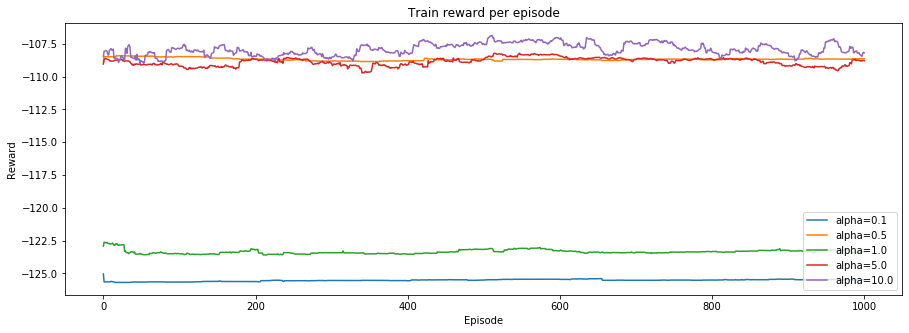

In [42]:
plt.figure(figsize = (15,5))

for alpha in alphas:
    train_rewards_mean = results_dict_5_min[alpha]['train_rewards_mean']
    plt.plot(train_rewards_mean, label = 'alpha='+str(alpha))

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Train reward per episode')
plt.legend(loc='lower right')

plt.show()

##### Plot best results

In [38]:
best_alpha = 10.0

In [39]:
# get mean results for train and test
train_rewards_mean = results_dict_5_min[best_alpha]['train_rewards_mean']
train_rewards_std = results_dict_5_min[best_alpha]['train_rewards_std']

test_rewards_mean = results_dict_5_min[best_alpha]['test_rewards_mean']
test_rewards_std = results_dict_5_min[best_alpha]['test_rewards_std']

# get optimal rewards for train and test
train_opt = compute_optimal_action_reward(train_instances, action_values, solved_mip_result_dict=solved_mip_result_dict)
test_opt = compute_optimal_action_reward(test_instances, action_values, solved_mip_result_dict=solved_mip_result_dict)

# get scip default rewards for train and test
train_scip_reward = compute_scip_action_reward(train_instances, solved_mip_result_dict=solved_mip_result_dict)
test_scip_reward = compute_scip_action_reward(test_instances, solved_mip_result_dict=solved_mip_result_dict)

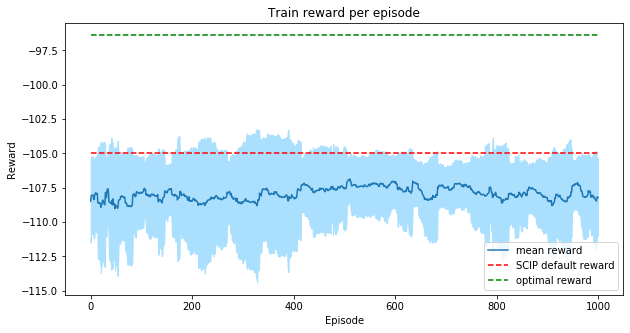

In [44]:
# plot train rewards
plt.figure(figsize =(10,5))

plt.plot(train_rewards_mean, label = 'mean reward')
plt.fill_between(range(episodes+1), train_rewards_mean, train_rewards_mean + train_rewards_std, color = '#AAE0FE')
plt.fill_between(range(episodes+1), train_rewards_mean, train_rewards_mean - train_rewards_std, color = '#AAE0FE')


plt.hlines(train_scip_reward, 0, episodes, linestyles='dashed', colors=['r'], label='SCIP default reward')
plt.hlines(train_opt, 0, episodes, linestyles='dashed', colors=['g'], label='optimal reward')

plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Train reward per episode')

plt.show()

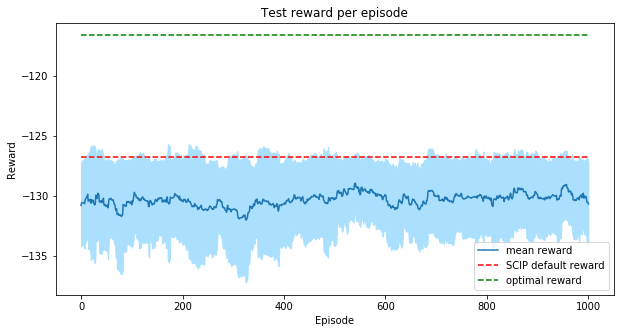

In [45]:
# plot test rewards
plt.figure(figsize =(10,5))

# mean and standard deviation results
plt.plot(test_rewards_mean, label = 'mean reward')
plt.fill_between(range(episodes+1), test_rewards_mean, test_rewards_mean + test_rewards_std, color = '#AAE0FE')
plt.fill_between(range(episodes+1), test_rewards_mean, test_rewards_mean - test_rewards_std, color = '#AAE0FE')

# mean and standard deviation results
plt.hlines(test_scip_reward, 0, episodes, linestyles='dashed', colors=['r'], label='SCIP default reward')
plt.hlines(test_opt, 0, episodes, linestyles='dashed', colors=['g'], label='optimal reward')

plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Test reward per episode')

plt.show()

## A view of individual learning curves

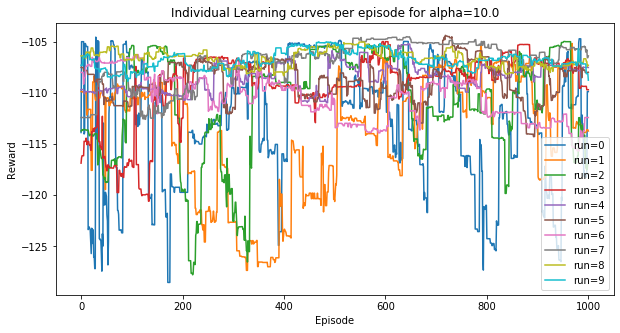

In [46]:
alpha = 10.0
train_rewards =  results_dict_5_min[alpha]['train_rewards']
n_curves = 10

plt.figure(figsize =(10,5))

# plot n_curves individual learning curves
for curve in range(n_curves):
    plt.plot(train_rewards[curve], label = 'run='+str(curve))
    


plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Individual Learning curves per episode for alpha=' +str(alpha))

plt.legend(loc = 'lower right')
plt.show()
    

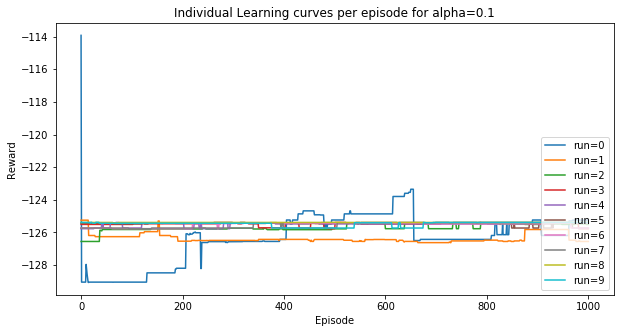

In [47]:
alpha = 0.1
train_rewards =  results_dict_5_min[alpha]['train_rewards']
n_curves = 10

plt.figure(figsize =(10,5))

# plot n_curves individual learning curves
for curve in range(n_curves):
    plt.plot(train_rewards[curve], label = 'run='+str(curve))
    


plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Individual Learning curves per episode for alpha=' +str(alpha))

plt.legend(loc = 'lower right')
plt.show()